<h1>Урок 2. UPLIFT на практике</h1>

Вернёмся к нашему "игрушечному датасету" и построим несколько Uplift-моделей, используя различные подходы, кроме того, измерим их качество и обсудим несколько аспектов, связанных с практическими аспектами построения Uplift-моделей. 

<h2>Импорты библиотек</h2>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split,
                                     cross_validate,
                                     StratifiedKFold)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftRandomForestClassifier

import optuna

from catboost import CatBoostClassifier

from sklift.models import (SoloModel,
                           TwoModels,
                           ClassTransformation,
                           ClassTransformationReg)
from sklift.metrics import (uplift_at_k,
                            uplift_auc_score,
                            qini_auc_score,
                            make_uplift_scorer)
from sklift.viz import plot_qini_curve, plot_uplift_curve

/home/art290790/projects/teaching/uplift_test/uplift-module-for-stepik-course/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to import duecredit due to No module named 'duecredit'


In [2]:
RANDOM_STATE = 42

<h2>Генерация данных</h2>

In [3]:
df, x_names = make_uplift_classification(
                                         treatment_name=['control', 'treatment1'],
                                         y_name = 'target',
                                         n_classification_features = 6,
                                         n_classification_informative = 5,
                                         n_samples = 80000,
                                         random_seed = RANDOM_STATE,
                                         positive_class_proportion=0.4,
                                         delta_uplift_increase_dict={'treatment1': 0.7})
df['treatment_group_key'] = df['treatment_group_key'].replace({'control':0, 'treatment1':1})
df.head()


df.treatment_group_key = df.treatment_group_key.astype('int')

In [4]:
df.head(5)

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_uplift_increase,x8_uplift_increase,x9_increase_mix,target,treatment_effect
0,1,1.177697,1.541399,1.729425,-2.089231,1.307060,-0.436698,0.265101,-1.068295,0.809188,0,0
1,0,1.011344,1.722951,-0.940343,-2.168505,0.595523,-1.301440,-1.173930,0.875189,1.805140,0,0
2,0,0.821249,1.566195,2.545513,-0.737370,1.326130,0.815585,-0.530246,-1.624725,1.130743,0,0
3,0,1.326766,2.319796,-0.188080,-1.759102,2.423625,-0.782383,1.604272,-0.767207,-0.122618,0,0
4,1,-0.531544,2.317090,1.833935,-1.256844,1.219159,0.128766,0.822677,-1.024798,-1.111676,0,0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'target'),
                                                    df.target,
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE,
                                                    stratify=df.target)

<h2>Обучение первой модели</h2>

Как решать задачу? В простейшем случае можно поступить следующим образом:

1. Обучим модель на X_train (с колонкой с флагом коммуникации)
2. Для построения предсказаний (predict_proba) uplift подадим X_test дважды - сначала указав в качестве флага коммуникации 0, а затем указав в качестве флага коммуникации 1

Этот подход называется Solomodel. 

In [6]:
model = LogisticRegression(random_state=RANDOM_STATE)

In [7]:
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [8]:
X_test_0 = X_test.copy()
X_test_0['treatment_group_key'] = 0
X_test_0.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_uplift_increase,x8_uplift_increase,x9_increase_mix,treatment_effect
115498,0,1.041977,1.255982,1.243169,-1.734968,2.187941,-0.134930,0.660124,-1.105819,0.378822,0
44588,0,0.782007,0.259977,1.108133,-0.698935,0.637570,1.733759,1.807316,-0.594610,-0.754895,0
1524,0,1.643051,-0.053244,-0.738051,-0.537680,-1.228152,1.129344,0.197765,-1.386496,1.265248,0
31846,0,1.923705,2.603550,2.426704,-2.892413,3.612205,-0.071553,0.509170,-1.332614,1.261451,0
109125,0,-0.613157,3.144509,2.023248,1.290579,-2.461636,1.374361,0.193449,-1.541778,-0.683868,0


In [9]:
y_pred_0 = model.predict_proba(X_test_0)[:,1]

In [10]:
X_test_1 = X_test.copy()
X_test_1['treatment_group_key'] = 1
X_test_1.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_uplift_increase,x8_uplift_increase,x9_increase_mix,treatment_effect
115498,1,1.041977,1.255982,1.243169,-1.734968,2.187941,-0.134930,0.660124,-1.105819,0.378822,0
44588,1,0.782007,0.259977,1.108133,-0.698935,0.637570,1.733759,1.807316,-0.594610,-0.754895,0
1524,1,1.643051,-0.053244,-0.738051,-0.537680,-1.228152,1.129344,0.197765,-1.386496,1.265248,0
31846,1,1.923705,2.603550,2.426704,-2.892413,3.612205,-0.071553,0.509170,-1.332614,1.261451,0
109125,1,-0.613157,3.144509,2.023248,1.290579,-2.461636,1.374361,0.193449,-1.541778,-0.683868,0


In [11]:
y_pred_1 = model.predict_proba(X_test_1)[:,1]

In [12]:
uplift_0 = y_pred_1 - y_pred_0

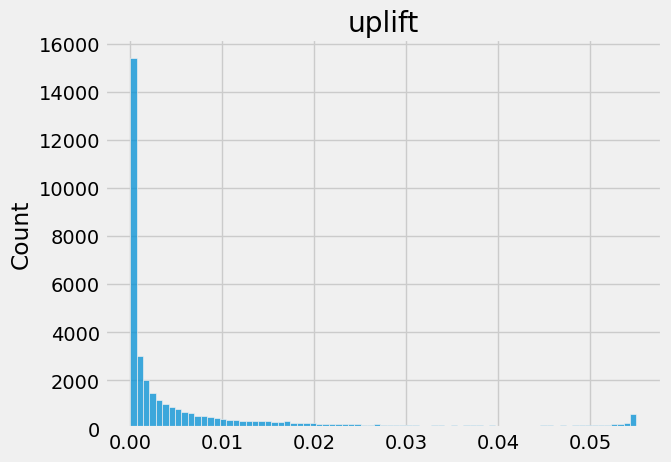

In [13]:
uplift_pd = pd.DataFrame(data = uplift_0, index = X_test.index, columns=['uplift'])
uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)
sns.histplot(data = uplift_pd, x=uplift_0).set_title('uplift')
plt.show()

<h2>Metalearners

<h3> Metalearners: Solomodel </h3>

Воспользуемся аналогичным подходом, как в предыдущем примере, но воспользуемся классом Solomodel из библиотеки Sklift. В качестве внутренней модели всё также будем использовать логистическую регрессию. 

In [14]:
X_train.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_uplift_increase,x8_uplift_increase,x9_increase_mix,treatment_effect
123978,0,1.687580,0.401663,1.293697,-0.951215,0.668669,-1.632120,0.112067,-1.368706,1.371669,0
81615,0,1.295748,0.816967,-1.833716,-1.616456,0.166231,0.767579,0.296047,-1.128303,0.886837,0
8940,0,0.876021,0.507386,1.143658,0.614864,-0.692011,0.773731,2.735195,-0.257823,-1.408545,0
59297,0,1.170057,-0.193652,-1.734495,4.297216,1.867451,-2.111822,-1.193722,0.817523,1.958169,0
31755,0,-1.279528,-1.597867,1.097725,1.198024,-0.891833,0.558784,0.089963,-1.271115,-1.178574,0


In [15]:
sm = SoloModel(estimator=model)

In [16]:
sm.fit(X_train.drop(columns='treatment_group_key'),
       y_train,
       treatment=X_train['treatment_group_key'])

SoloModel(estimator=LogisticRegression(random_state=42))

In [17]:
uplift_1 = sm.predict(X_test.drop(columns='treatment_group_key'))

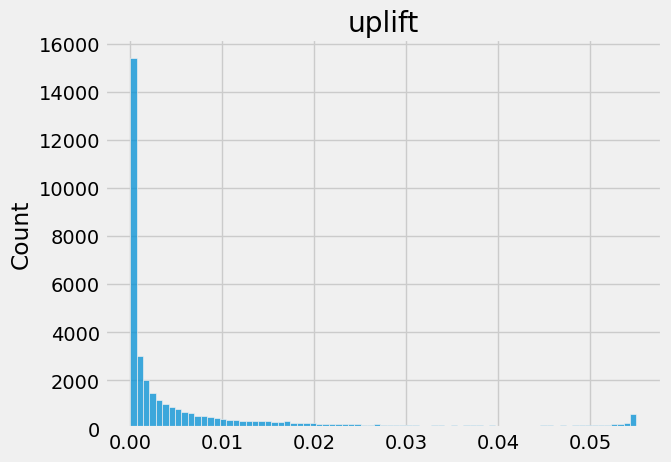

In [18]:
uplift_pd = pd.DataFrame(data = uplift_1, index = X_test.index, columns=['uplift'])
uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)
sns.histplot(data = uplift_pd, x=uplift_0).set_title('uplift')
plt.show()

In [19]:
np.linalg.norm(uplift_0 - uplift_1) / np.linalg.norm(uplift_1)

3.0766930622256033e-14

Таким образом мы получили идентичные результаты, как с наивным подходом, так и с помощью Solomodel. Посмотрим, какое получилось качество Uplift

In [20]:
uplift_at_k(y_true=y_test,
            uplift=uplift_1,
            treatment=X_test['treatment_group_key'],
            strategy='by_group',
            k=0.2)

0.04815353838459624

In [21]:
uplift_auc_score(y_true=y_test,
                 uplift=uplift_1,
                 treatment=X_test['treatment_group_key'])

-0.08168757366144663

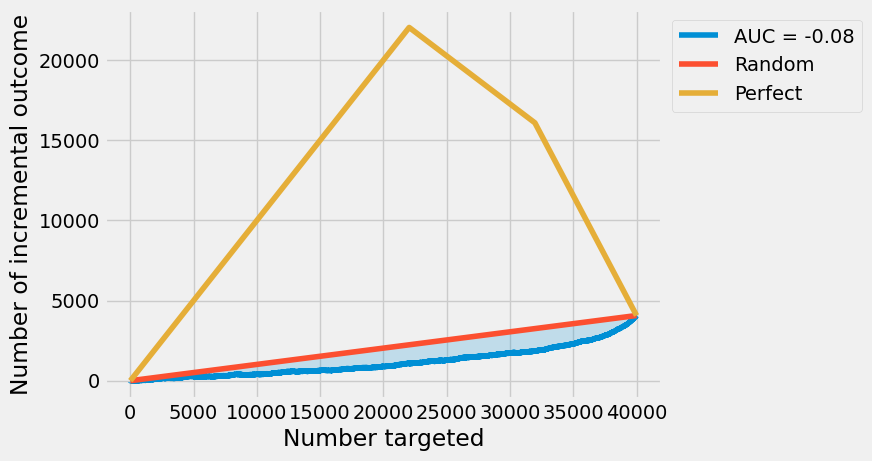

In [22]:
plot_uplift_curve(y_true=y_test,
                  uplift=pd.Series(uplift_1, index=X_test.index),
                  treatment=X_test['treatment_group_key'])
plt.show()

In [23]:
qini_auc_score(y_true=y_test,
               uplift=pd.Series(uplift_1, index=X_test.index),
               treatment=X_test['treatment_group_key'])

-0.06589747840087457

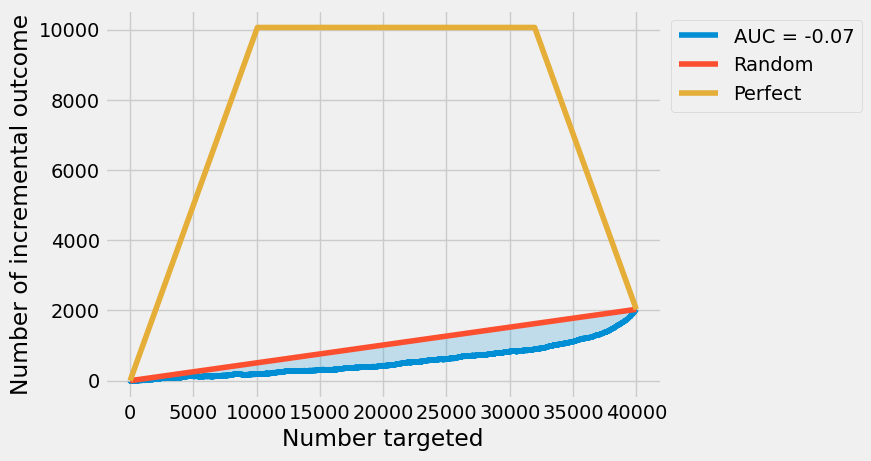

In [24]:
plot_qini_curve(y_true=y_test,
                  uplift=pd.Series(uplift_1, index=X_test.index),
                  treatment=X_test['treatment_group_key'])
plt.show()

Получившееся качество довольно невысоко. Попробуем другие подходы и другие модели в качестве базовых. Также попробуем осуществить тюнинг гиперпараметров. Далее в качестве метрики будем использовать qini_auc_score.

<h3> Metalearners: Twomodels </h3> Здесь мы уже будем использовать две модели, которые обучаются на контрольной и целевой частях датасета. Рассмотрим подход с использованием независимых и зависимых моделей, как мы обсудили ранее. 

In [25]:
model_1 = LogisticRegression(random_state=RANDOM_STATE+1)
model_2 = LogisticRegression(random_state=RANDOM_STATE+2)

In [26]:
#независимые модели
tm_ind = TwoModels(estimator_trmnt=model_1,
                   estimator_ctrl=model_2,
                   method='vanilla')

In [27]:
tm_ind.fit(X_train.drop(columns='treatment_group_key'),
           y_train,
           treatment=X_train['treatment_group_key'])

TwoModels(estimator_ctrl=LogisticRegression(random_state=44),
          estimator_trmnt=LogisticRegression(random_state=43))

In [28]:
uplift_2 = tm_ind.predict(X_test.drop(columns='treatment_group_key'))

In [29]:
qini_auc_score(y_true=y_test,
               uplift=pd.Series(uplift_2, index=X_test.index),
               treatment=X_test['treatment_group_key'])

0.11984679488407343

In [30]:
#зависимые модели
tm_not_ind = TwoModels(estimator_trmnt=model_1,
                       estimator_ctrl=model_2,
                       method='ddr_control')

In [31]:
tm_not_ind.fit(X_train.drop(columns='treatment_group_key'),
               y_train,
               treatment=X_train['treatment_group_key'])

TwoModels(estimator_ctrl=LogisticRegression(random_state=44),
          estimator_trmnt=LogisticRegression(random_state=43),
          method='ddr_control')

In [32]:
uplift_3 = tm_not_ind.predict(X_test.drop(columns='treatment_group_key'))

In [33]:
qini_auc_score(y_true=y_test,
               uplift=pd.Series(uplift_3, index=X_test.index),
               treatment=X_test['treatment_group_key'])

0.12597430704148244

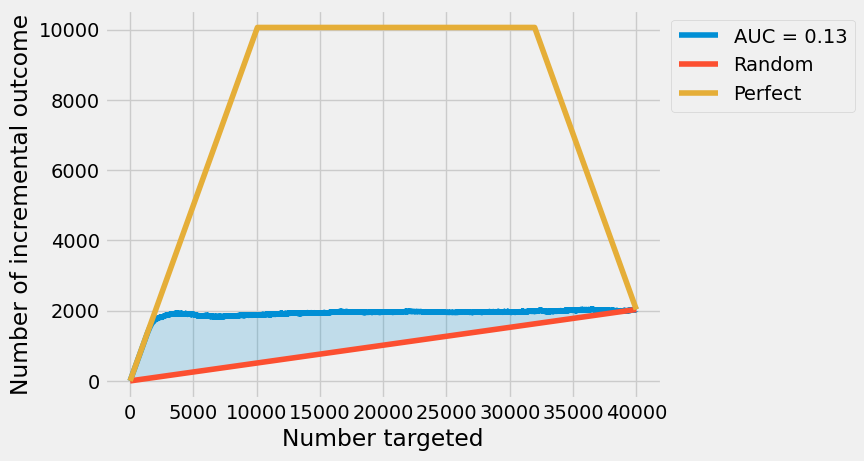

In [34]:
plot_qini_curve(y_true=y_test,
                  uplift=pd.Series(uplift_3, index=X_test.index),
                  treatment=X_test['treatment_group_key'])
plt.show()

Несколько лучше, чем было раньше. Есть три гипотезы о том, как можно попробовать улучшить качество в рамках использования Metalearners
1. Перед подачей в LogisticRegression данные необходимо предобрабатывать (как минимум осуществлять скейлинг), однако как создать pipeline при условии того, что мы пользуемся Uplift моделью (инференс модели отличается от обучения еще и тем, что используется флаг коммуникации) не совсем понятно.
2. Тюнинг гиперпараметров. Однако здесь возникает аналогичная проблема, связанная с тем, что "стандартная" кросс-валидация ничего не знает про Uplift-моделирование.
3. Можно попробовать другие модели в качестве базовых (например градиентный бустинг), но здесь возникает проблема с калибровкой моделей 
 

<h3> Использование пайплайнов для uplift-моделирования </h3>

In [35]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('model_uplift', tm_not_ind)
])

In [36]:
pipe.fit(X_train.drop(columns='treatment_group_key'),
         y_train,
         model_uplift__treatment=X_train['treatment_group_key'])

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model_uplift',
                 TwoModels(estimator_ctrl=LogisticRegression(random_state=44),
                           estimator_trmnt=LogisticRegression(random_state=43),
                           method='ddr_control'))])

In [37]:
uplift_4 = pipe.predict(X_test.drop(columns='treatment_group_key'))

In [38]:
qini_auc_score(y_true=y_test,
               uplift=pd.Series(uplift_4, index=X_test.index),
               treatment=X_test['treatment_group_key'])

0.12392296622729652

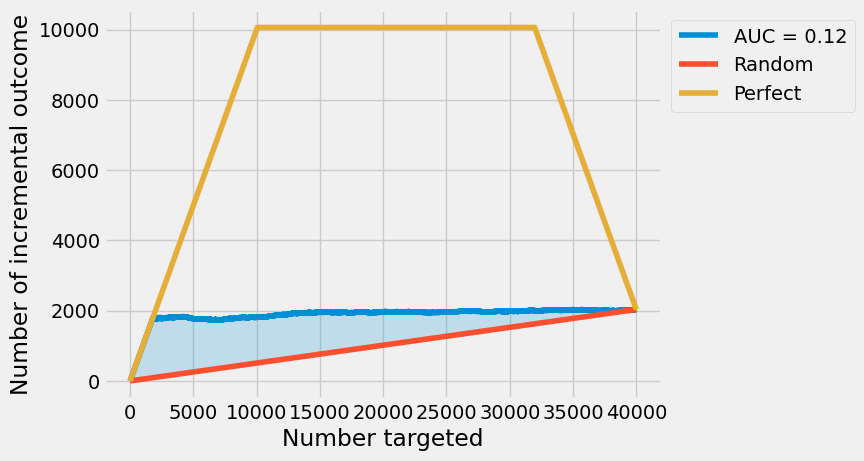

In [39]:
plot_qini_curve(y_true=y_test,
                  uplift=pd.Series(uplift_4, index=X_test.index),
                  treatment=X_test['treatment_group_key'])
plt.show()

У нас получилось несколько улучшить качество таким образом. Важно понимать, что параметр model_uplift__treatment в методе fit формируется следующим образом: название этапа (в данном случае это model_uplift) + '__' + название параметра. Здесь мы передаем колонку с флагом коммуникации. 

<h3> Калибровка моделей для Uplift моделирования</h3> Чтобы использовать какие-то другие внутренние модели помимо логистической регрессии, нам необходимо осуществлять калибровку моделей, чтобы они выдавали честные вероятности, только в этом случае мы сможем корректно считать uplift. Можно воспользоваться следующим подходом.

In [40]:
skf = StratifiedKFold(n_splits=5,
                      random_state=RANDOM_STATE,
                      shuffle=True)

In [41]:
model_1_cb = CatBoostClassifier(verbose=0, random_seed=RANDOM_STATE, thread_count=-1)
model_2_cb = CatBoostClassifier(verbose=0, random_seed=RANDOM_STATE+1, thread_count=-1)

calib_model_1 = CalibratedClassifierCV(estimator=model_1_cb, method='isotonic', cv=skf)
calib_model_2 = CalibratedClassifierCV(estimator=model_2_cb, method='isotonic', cv=skf)

In [42]:
tm_catboost = TwoModels(estimator_trmnt=calib_model_1,
                        estimator_ctrl=calib_model_2)

In [43]:
tm_catboost.fit(X_train.drop(columns='treatment_group_key'),
                y_train,
                treatment=X_train['treatment_group_key'])

TwoModels(estimator_ctrl=CalibratedClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                                estimator=<catboost.core.CatBoostClassifier object at 0xffa089392c50>,
                                                method='isotonic'),
          estimator_trmnt=CalibratedClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                                 estimator=<catboost.core.CatBoostClassifier object at 0xffa089390c70>,
                                                 method='isotonic'))

In [44]:
uplift_5 = tm_catboost.predict(X_test.drop(columns='treatment_group_key'))

In [45]:
qini_auc_score(y_true=y_test,
                 uplift=uplift_5,
                 treatment=X_test['treatment_group_key'])

0.13674726082724395

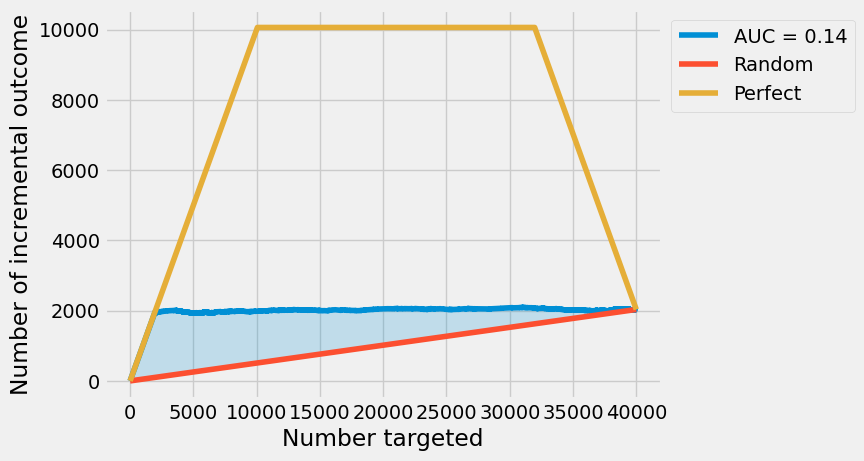

In [46]:
plot_qini_curve(y_true=y_test,
                  uplift=pd.Series(uplift_5, index=X_test.index),
                  treatment=X_test['treatment_group_key'])
plt.show()

In [47]:
sm_catboost = SoloModel(estimator=calib_model_1)

In [48]:
sm_catboost.fit(X_train.drop(columns='treatment_group_key'),
                y_train,
                treatment=X_train['treatment_group_key'])

SoloModel(estimator=CalibratedClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                           estimator=<catboost.core.CatBoostClassifier object at 0xffa089390c70>,
                                           method='isotonic'))

In [49]:
uplift_6 = sm_catboost.predict(X_test.drop(columns='treatment_group_key'))

In [50]:
qini_auc_score(y_true=y_test,
                 uplift=uplift_6,
                 treatment=X_test['treatment_group_key'])

0.11008731363000941

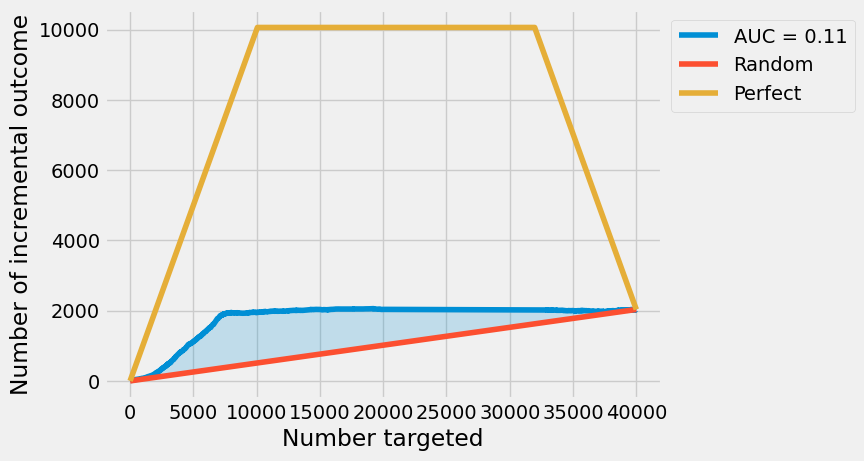

In [51]:
plot_qini_curve(y_true=y_test,
                  uplift=pd.Series(uplift_6, index=X_test.index),
                  treatment=X_test['treatment_group_key'])
plt.show()

<h3>Тюнинг гиперпараметров для Uplift моделирования </h3> Напишем свою кросс-валидацию для вычисления qini_score.

In [52]:
X_train.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_uplift_increase,x8_uplift_increase,x9_increase_mix,treatment_effect
123978,0,1.687580,0.401663,1.293697,-0.951215,0.668669,-1.632120,0.112067,-1.368706,1.371669,0
81615,0,1.295748,0.816967,-1.833716,-1.616456,0.166231,0.767579,0.296047,-1.128303,0.886837,0
8940,0,0.876021,0.507386,1.143658,0.614864,-0.692011,0.773731,2.735195,-0.257823,-1.408545,0
59297,0,1.170057,-0.193652,-1.734495,4.297216,1.867451,-2.111822,-1.193722,0.817523,1.958169,0
31755,0,-1.279528,-1.597867,1.097725,1.198024,-0.891833,0.558784,0.089963,-1.271115,-1.178574,0


Пишем свою кастомную кросс-валидацию под новый scorer

In [53]:
qini_scorer = make_uplift_scorer("qini_auc_score", X_train['treatment_group_key'])


# Use this object in model selection functions
cross_validate(tm_ind,
               X=X_train.drop(columns='treatment_group_key'),
               y=y_train,
               fit_params={'treatment': X_train['treatment_group_key']},
               scoring=qini_scorer,
               cv=skf,
               n_jobs=-1,
               return_train_score=True)


{'fit_time': array([0.19531131, 0.18021226, 0.19178367, 0.19836211, 0.18618965]),
 'score_time': array([0.02543259, 0.02560425, 0.02573347, 0.01507235, 0.01784372]),
 'test_score': array([0.12257582, 0.12970733, 0.12681821, 0.13431078, 0.1408933 ]),
 'train_score': array([0.13341531, 0.13160958, 0.13192973, 0.13037538, 0.12870965])}

In [54]:
def objective_tm_lr(trial):

    param = {
            'C_1':trial.suggest_float("C_1", 0, 3),
            'C_2':trial.suggest_float("C_2", 0, 3),
            'method':trial.suggest_categorical("method", ['vanilla', 'ddr_control', 'ddr_treatment'])
    }
    #если бы у нас была не логрегрессия, то мы бы еще обернули в CalibratedClassifier
    model_1 = LogisticRegression(random_state=RANDOM_STATE+1, C=param['C_1'])
    model_2 = LogisticRegression(random_state=RANDOM_STATE+2, C=param['C_2'])

    tm = TwoModels(estimator_trmnt=model_1,
                       estimator_ctrl=model_2,
                       method=param['method'])
    
    pipe = Pipeline(steps=[('scaler', MinMaxScaler()),
                           ('model_uplift', tm)])
    
    qini_scorer = make_uplift_scorer("qini_auc_score", X_train['treatment_group_key'])

    cross_val = cross_validate(pipe,
                               X=X_train.drop(columns='treatment_group_key'),
                               y=y_train,
                               fit_params={'model_uplift__treatment':X_train['treatment_group_key']},
                               scoring=qini_scorer,
                               cv=skf,
                               n_jobs=-1,
                               return_train_score=True)

    #мы ищем не просто самую лучшую модель, а самую стабильную
    return cross_val['test_score'].mean() - cross_val['test_score'].std()

optuna.logging.set_verbosity(optuna.logging.WARNING)

study_tm = optuna.create_study(direction="maximize")
study_tm.optimize(objective_tm_lr,
                  n_trials=500,
                  show_progress_bar=True)

Best trial: 2. Best value: 0.127086:   1%|          | 3/500 [00:02<07:25,  1.12it/s]/home/art290790/projects/teaching/uplift_test/uplift-module-for-stepik-course/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Best trial: 2. Best value: 0.127086:   1%|          | 6/500 [00:05<06:48,  1.21it/s]/home/art290790/projects/teaching/uplift_test/uplift-module-for-stepik-course/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIM

<div class="alert alert-warning"><b>Подумайте над следующим вопросом.</b> Вообще говоря, тот подход, который использовался для скейлинга для обучения Twomodels не совсем верен. Twomodels предполагает обучение двух независимых моделей, каждая из которых обучается на своём датасете (контрольная и целевая выборка) и соответственно, скейлинг (как и любую другую предобработку) каждого датасета перед подачей в модель, вообще говоря, необходимо проводить независимо. Но тем не менее, такой подход, вполне допустим. Объясните, почему это так.  </div>

Аналогичным образом можно сделать тюнинг другого Metalearner'а с другими базовыми алгоритмами.

<h2>Преобразование классов

In [55]:
ct = ClassTransformation(model_1_cb)
# fit the model
ct = ct.fit(X_train.drop(columns='treatment_group_key'),
                y_train,
                treatment=X_train['treatment_group_key'])
# predict uplift
uplift_ct = ct.predict(X_test.drop(columns='treatment_group_key'))

In [56]:
qini_auc_score(y_true=y_test,
                 uplift=uplift_ct,
                 treatment=X_test['treatment_group_key'])

0.139756993293138

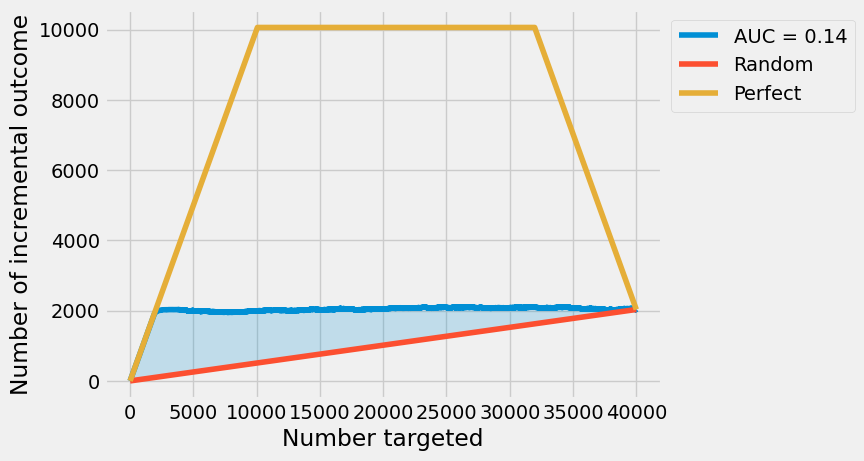

In [58]:
plot_qini_curve(y_true=y_test,
                  uplift=pd.Series(uplift_ct, index=X_test.index),
                  treatment=X_test['treatment_group_key'])
plt.show()

In [59]:
ct = ClassTransformationReg(estimator=LinearRegression(),
                            propensity_estimator=LogisticRegression())
# fit the model
ct = ct.fit(X_train.drop(columns='treatment_group_key'),
                y_train,
                treatment=X_train['treatment_group_key'])
# predict uplift
uplift_ct = ct.predict(X_test.drop(columns='treatment_group_key'))

In [60]:
qini_auc_score(y_true=y_test,
                 uplift=uplift_ct,
                 treatment=X_test['treatment_group_key'])

0.12029925455540595

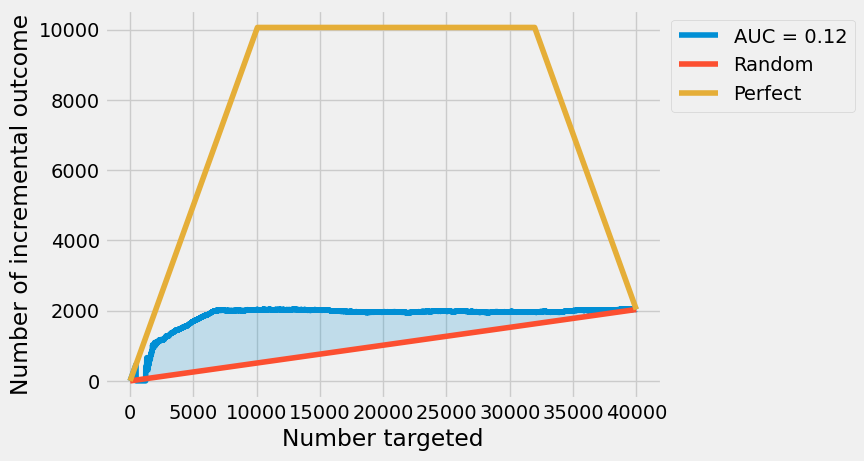

In [61]:
plot_qini_curve(y_true=y_test,
                  uplift=pd.Series(uplift_ct, index=X_test.index),
                  treatment=X_test['treatment_group_key'])
plt.show()

<div class="alert alert-warning"><b>Подумайте над следующим вопросом.</b> Почему при трансформации классов  мы не использовали калибровку вероятностей для вычисления qini_score?  </div>

В части использования в пайплайнах и тюнинга модели здесь применимо всё, что говорилось про Metalearners.

<h2> Алгоритмы, основанные на Uplift-деревьях </h2> Продемонстрируем работу случайного леса на основе Uplift деревьев

In [62]:
X_train.head(5)

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_uplift_increase,x8_uplift_increase,x9_increase_mix,treatment_effect
123978,0,1.687580,0.401663,1.293697,-0.951215,0.668669,-1.632120,0.112067,-1.368706,1.371669,0
81615,0,1.295748,0.816967,-1.833716,-1.616456,0.166231,0.767579,0.296047,-1.128303,0.886837,0
8940,0,0.876021,0.507386,1.143658,0.614864,-0.692011,0.773731,2.735195,-0.257823,-1.408545,0
59297,0,1.170057,-0.193652,-1.734495,4.297216,1.867451,-2.111822,-1.193722,0.817523,1.958169,0
31755,0,-1.279528,-1.597867,1.097725,1.198024,-0.891833,0.558784,0.089963,-1.271115,-1.178574,0


In [63]:
uplift_forest = UpliftRandomForestClassifier(control_name='0',
                                             random_state=RANDOM_STATE)

У библиотеки CausalML несколько другой синтаксис, чем у Sklift, поэтому колонка с флагом коммуникации должна быть категориальной. 

In [64]:
X_train['treatment_group_key'] = X_train['treatment_group_key'].astype('str')
X_test['treatment_group_key'] = X_test['treatment_group_key'].astype('str')

In [65]:
uplift_forest.fit(X=X_train.drop(columns='treatment_group_key').values,
                  y=y_train.values,
                  treatment=X_train['treatment_group_key'].values)

In [66]:
uplift_fr = uplift_forest.predict(X=X_test.drop(columns='treatment_group_key').values)

In [72]:
qini_auc_score(y_true=y_test,
                 uplift=uplift_fr.reshape(-1),
                 treatment=X_test['treatment_group_key'].astype('int'))

0.12329715656001157

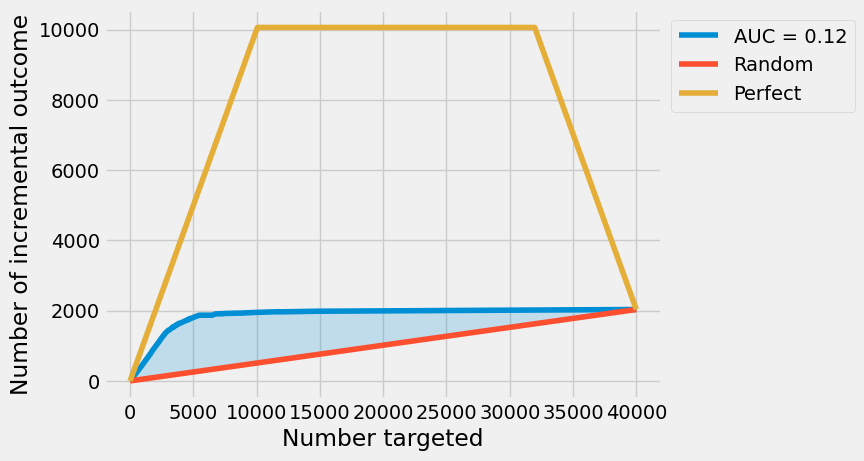

In [74]:
plot_qini_curve(y_true=y_test,
                  uplift=pd.Series(uplift_fr.reshape(-1), index=X_test.index),
                  treatment=X_test['treatment_group_key'].astype(int))
plt.show()

<h1> Бонус: стратификация при Uplift-моделировании </h1> В данном ноутбуке мы упустили одну важную вещь, а именно: стратификация. То есть представим себе ситуацию, когда продукт, для которого вы планируете построить модель имеет очень низкую долю покупок (например, 3-4%, что довольно типично). Соответственно, при разбиении необходимо учесть стратификацию по таргету. Однако, в данном случае, может возникнуть проблема: при стратификации по таргету есть риск того, что доли целевой и контрольной группы будут отличаться в тренировочной и тестовой выборке. Соответственно, <b>необходимо стратифицировать дополнительно по флагу коммуникации.</b> Это можно сделать следующим образом: создаем новую колонку, которую представим парами значение таргета _ значение коммуникации

In [75]:
to_stratify = df['target'].astype(str) + '_' + df['treatment_group_key'].astype(str) 

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'target'),
                                                    df.target,
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE,
                                                    stratify=to_stratify)